In [ ]:
import torch
from PIL import Image
import torchvision.transforms.functional as TF
from pytorch_msssim import ms_ssim

from compressai.zoo import bmshj2018_hyperprior

def eval_hyperprior(image_path, quality_levels=[2, 5, 8]):
    img = Image.open(image_path).convert("RGB")
    x = TF.to_tensor(img).unsqueeze(0)  # [1,3,H,W]

    results = []
    for q in quality_levels:
        model = bmshj2018_hyperprior(quality=q, metric='ms-ssim', pretrained=True).eval()
        with torch.no_grad():
            out = model.compress(x)

            total_bits = sum(len(s) * 8 for s in out["strings"][0])
            num_pixels = x.size(-2) * x.size(-1)
            bpp = total_bits / num_pixels

            dec = model.decompress(out["strings"], out["shape"])
            x_hat = dec["x_hat"].clamp(0, 1)

            # crop reconstruction back to original size
            x_hat = x_hat[:, :, :x.size(-2), :x.size(-1)]

            # MS-SSIM with smaller win_size and 3 scales
            mss = ms_ssim(
                x_hat, x,
                data_range=1.0,
                size_average=True,
                win_size=7,
                weights=[0.4, 0.3, 0.3]
            ).item()

        results.append((q, bpp, mss))
        print(f"Quality {q}: bpp = {bpp:.3f}, MS-SSIM = {mss:.4f}")

    return results

if __name__ == "__main__":
    eval_hyperprior("/dcs/large/u2157170/code/results/S2A_MSIL2A_20170905T095031_N9999_R079_T35VNL_00_00_RGB.png")


Quality 2: bpp = 0.202, MS-SSIM = 0.7461
Downloading: "https://compressai.s3.amazonaws.com/models/v1/bmshj2018-hyperprior-ms-ssim-5-c34afc8d.pth.tar" to /dcs/pg24/u2157170/.cache/torch/hub/checkpoints/bmshj2018-hyperprior-ms-ssim-5-c34afc8d.pth.tar


100%|██████████| 20.2M/20.2M [00:01<00:00, 11.7MB/s]


Quality 5: bpp = 0.636, MS-SSIM = 0.8571
Downloading: "https://compressai.s3.amazonaws.com/models/v1/bmshj2018-hyperprior-ms-ssim-8-cc15b5f3.pth.tar" to /dcs/pg24/u2157170/.cache/torch/hub/checkpoints/bmshj2018-hyperprior-ms-ssim-8-cc15b5f3.pth.tar


100%|██████████| 45.9M/45.9M [00:03<00:00, 15.1MB/s]


Quality 8: bpp = 1.738, MS-SSIM = 0.9200


Quality 2: bpp = 0.173, MS-SSIM = 0.7939
Quality 5: bpp = 0.638, MS-SSIM = 0.8947
Quality 8: bpp = 2.369, MS-SSIM = 0.9413

Saved combined visualization to: /dcs/large/u2157170/code/resultsanalysis/S2A_MSIL2A_20170905T095031_N9999_R079_T35VNL_00_02_RGB_reconstructions.png


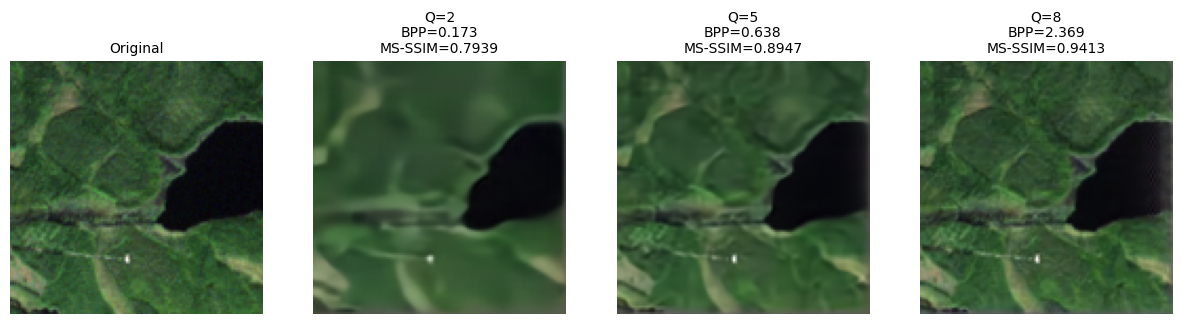

In [1]:
import torch
from PIL import Image
import torchvision.transforms.functional as TF
from pytorch_msssim import ms_ssim
from compressai.zoo import bmshj2018_hyperprior
import matplotlib.pyplot as plt
import os

def eval_hyperprior(image_path, quality_levels=[2, 5, 8]):
    """
    Evaluates the Balle et al. (2018) hyperprior model for image compression
    at different quality levels and visualizes the reconstructions.
    """
    img = Image.open(image_path).convert("RGB")
    x = TF.to_tensor(img).unsqueeze(0)  # [1,3,H,W]

    results = []
    
    # Create a list to store images for visualization
    images_to_show = [img] 
    titles = ["Original"]

    for q in quality_levels:
        model = bmshj2018_hyperprior(quality=q, metric='mse', pretrained=True).eval()
        with torch.no_grad():
            out = model.compress(x)

            total_bits = sum(len(s) * 8 for s in out["strings"][0])
            num_pixels = x.size(-2) * x.size(-1)
            bpp = total_bits / num_pixels

            dec = model.decompress(out["strings"], out["shape"])
            x_hat = dec["x_hat"].clamp(0, 1)

            # crop reconstruction back to original size
            x_hat = x_hat[:, :, :x.size(-2), :x.size(-1)]

            mss = ms_ssim(
                x_hat, x,
                data_range=1.0,
                size_average=True,
                win_size=7,
                weights=[0.4, 0.3, 0.3]
            ).item()

        results.append((q, bpp, mss))
        print(f"Quality {q}: bpp = {bpp:.3f}, MS-SSIM = {mss:.4f}")

        # Convert the reconstructed tensor to a PIL Image
        reconstructed_img = TF.to_pil_image(x_hat.squeeze(0))
        images_to_show.append(reconstructed_img)
        titles.append(f"Q={q}\nBPP={bpp:.3f}\nMS-SSIM={mss:.4f}")

    # Visualize the images side by side
    plt.figure(figsize=(15, 5))
    for i, (image, title) in enumerate(zip(images_to_show, titles)):
        ax = plt.subplot(1, len(images_to_show), i + 1)
        ax.imshow(image)
        ax.set_title(title, fontsize=10)
        ax.axis("off")
    
    # Save the combined visualization
    output_dir = "/dcs/large/u2157170/code/resultsanalysis/"#os.path.dirname(image_path)
    output_filename = os.path.splitext(os.path.basename(image_path))[0] + "_reconstructions.png"
    output_path = os.path.join(output_dir, output_filename)
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    print(f"\nSaved combined visualization to: {output_path}")

    return results

if __name__ == "__main__":
    eval_hyperprior("/dcs/large/u2157170/code/results/S2A_MSIL2A_20170905T095031_N9999_R079_T35VNL_00_02_RGB.png")

Quality 2: bpp = 0.171, MS-SSIM = 0.8151
Quality 5: bpp = 0.540, MS-SSIM = 0.8923
Quality 8: bpp = 1.464, MS-SSIM = 0.9349

Saved combined visualization to: /dcs/large/u2157170/code/resultsanalysis/S2A_MSIL2A_20170905T095031_N9999_R079_T35VNL_00_02_RGB_reconstructions.png


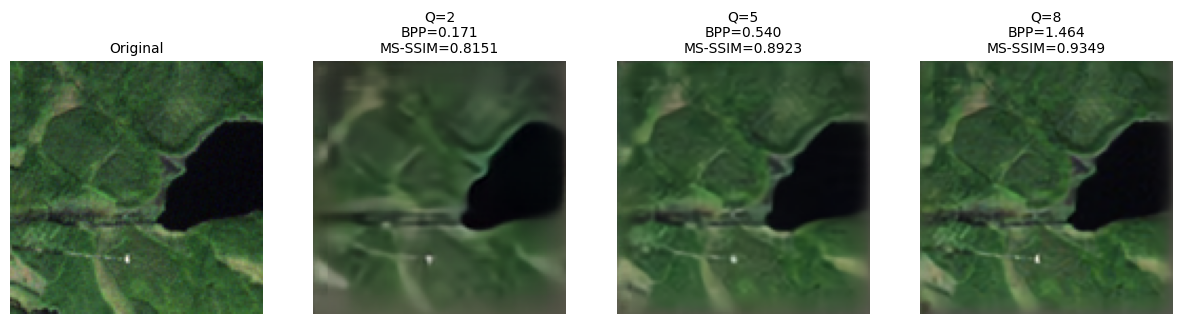

In [2]:
import torch
from PIL import Image
import torchvision.transforms.functional as TF
from pytorch_msssim import ms_ssim
from compressai.zoo import bmshj2018_hyperprior
import matplotlib.pyplot as plt
import os

def eval_hyperprior(image_path, quality_levels=[2, 5, 8]):
    """
    Evaluates the Balle et al. (2018) hyperprior model for image compression
    at different quality levels and visualizes the reconstructions.
    """
    img = Image.open(image_path).convert("RGB")
    x = TF.to_tensor(img).unsqueeze(0)  # [1,3,H,W]

    results = []
    
    # Create a list to store images for visualization
    images_to_show = [img] 
    titles = ["Original"]

    for q in quality_levels:
        model = bmshj2018_hyperprior(quality=q, metric='ms-ssim', pretrained=True).eval()
        with torch.no_grad():
            out = model.compress(x)

            total_bits = sum(len(s) * 8 for s in out["strings"][0])
            num_pixels = x.size(-2) * x.size(-1)
            bpp = total_bits / num_pixels

            dec = model.decompress(out["strings"], out["shape"])
            x_hat = dec["x_hat"].clamp(0, 1)

            # crop reconstruction back to original size
            x_hat = x_hat[:, :, :x.size(-2), :x.size(-1)]

            mss = ms_ssim(
                x_hat, x,
                data_range=1.0,
                size_average=True,
                win_size=7,
                weights=[0.4, 0.3, 0.3]
            ).item()

        results.append((q, bpp, mss))
        print(f"Quality {q}: bpp = {bpp:.3f}, MS-SSIM = {mss:.4f}")

        # Convert the reconstructed tensor to a PIL Image
        reconstructed_img = TF.to_pil_image(x_hat.squeeze(0))
        images_to_show.append(reconstructed_img)
        titles.append(f"Q={q}\nBPP={bpp:.3f}\nMS-SSIM={mss:.4f}")

    # Visualize the images side by side
    plt.figure(figsize=(15, 5))
    for i, (image, title) in enumerate(zip(images_to_show, titles)):
        ax = plt.subplot(1, len(images_to_show), i + 1)
        ax.imshow(image)
        ax.set_title(title, fontsize=10)
        ax.axis("off")
    
    # Save the combined visualization
    output_dir = "/dcs/large/u2157170/code/resultsanalysis/"#os.path.dirname(image_path)
    output_filename = os.path.splitext(os.path.basename(image_path))[0] + "_reconstructions.png"
    output_path = os.path.join(output_dir, output_filename)
    plt.savefig(output_path, bbox_inches='tight', dpi=300)
    print(f"\nSaved combined visualization to: {output_path}")

    return results

if __name__ == "__main__":
    eval_hyperprior("/dcs/large/u2157170/code/results/S2A_MSIL2A_20170905T095031_N9999_R079_T35VNL_00_02_RGB.png")